<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Дополнительные-вычисления" data-toc-modified-id="Дополнительные-вычисления-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Дополнительные вычисления</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><em>Общий вывод</em></a></span></li></ul></div>

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Маркетологи посчитали, что продуктивнее сохранить старых, чем искать новых. Откуда вытекает следующая задача: найти причину оттока клиентов. Для этого нужно построить модели, способные прогнозировать, уйдет ли клиент в ближайшее время или нет. Следует учесть дисбаланс классов в выборке и делать основные выводы по f1-метрике.

# Отток клиентов

In [1]:
# imblearn для применения встроенных методов борьбы с дисбалансом
#pip install imblearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [3]:
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

## Подготовка данных

In [4]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/YP/Churn.csv')

In [5]:
# Посмотрим на данные
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Однозначно нам пригодятся не все столбцы. RowNumber можем смело удалить и нужно понять, что делать с CustomerId и Surname, т.к. по факту это просто те данные, по которым можно идентифицировать пользователя, но как таковые в расчете нам их использовать возможно и не нужно. Для Gender и Geography придется применить прямое кодирование. Избавиться от пропусков в Tenure	 можно заменой медианным значением (можно корреляцию по категориям посмотреть), или просто удалением пропусков, а может и самого признака.

В одной колонке есть пропуски, пока чем их заменить непонятно. Для начала проверим каждая ли строка - это новый id или они могут повториться.

In [6]:
len(df['CustomerId'].value_counts())

10000

In [7]:
df1 = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df1

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Посмотрим наблюдается ли какая-то корреляция по полю Tenure

In [8]:
df1_corr = df1.corr()
df1_corr['Tenure'].sort_values(ascending=False)

Tenure             1.000000
HasCrCard          0.027232
NumOfProducts      0.011979
EstimatedSalary    0.010520
CreditScore       -0.000062
Balance           -0.007911
Age               -0.013134
Exited            -0.016761
IsActiveMember    -0.032178
Name: Tenure, dtype: float64

Корреляция со всеми осатльными признаками не очень...

In [9]:
df1.groupby(['Geography', 'Gender']).agg({'Tenure': 'median'})

Tenure
Geography Gender        
France    Female     5.0
          Male       5.0
Germany   Female     5.0
          Male       5.0
Spain     Female     5.0
          Male       5.0

Ну, в соответствии с вышесказанным и медианное значение в разбивке по группам оказалось одинаковым. 

Тогда им пропуски и заменим. А в итоге вернемся к этому моменту, идентификаторам пользователей и посмотрим как себя поведет моедль, если допустим удалить строки с пропусками в Tenure или все-таки оставить такой столбец как CustomerId

In [10]:
df1['Tenure'] = df1['Tenure'].fillna(df1['Tenure'].median())

Свиду ненужные признаки убрали, переведем в числовой формат текстовые столбцы.

Скорее всего, признаки придется еще и масштабировать, так как разброс явно немаленький. В принципе NumOfProducts и Tenure могут быть и категориальными... Но по факту они принимают хначения больше 1 (т.е., к примеру, 2, 4, 6 и т.п.), значит, промасштабируем их тоже, чтобы алгоритм не выбрал какой-то из них наиболее важным. Разделим признаки с целью на соотв-ие выборки и промасштабтруем.

In [11]:

features = df1.drop(['Exited'], axis=1)
target = df1['Exited']
f_train, f_pre, t_train, t_pre = train_test_split(features, target, test_size=0.4, random_state=12345)
f_valid, f_test, t_valid, t_test = train_test_split(f_pre, t_pre, test_size=0.5, random_state=12345)
print('Размеры тренировочной, валидационной и тестоыой выборок:', f_train.shape, f_valid.shape, f_test.shape)
print('Размеры целевых признаков ааналогичных выборок', t_train.shape, t_valid.shape, t_test.shape)
f_train.head()

Размеры тренировочной, валидационной и тестоыой выборок: (6000, 10) (2000, 10) (2000, 10)
Размеры целевых признаков ааналогичных выборок (6000,) (2000,) (2000,)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,567,Spain,Male,35,8.0,153137.74,1,1,0,88659.07
3411,711,France,Female,37,8.0,113899.92,1,0,0,80215.20
6027,850,Germany,Male,44,3.0,140393.65,2,0,1,186285.52
1247,512,France,Male,24,6.0,0.00,2,1,0,37654.31
3716,665,Germany,Female,27,2.0,147435.96,1,0,0,187508.06


Теперь получается, что мы можем поработать с признаками по отдельности. Сначала пприведем категориальные признаки к численным, затем масшттабируем все признаки.

In [12]:
list_1 = []
for sample in [f_train, f_valid, f_test]:
    enc_sample = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
    sample_ohe = pd.DataFrame(enc_sample.fit_transform(sample[['Gender', 'Geography']]))
    sample_ohe.index = sample.index
    sample_num = sample.drop(columns=['Gender', 'Geography'], axis=1)
    sample = pd.concat([sample_num, sample_ohe], axis=1)
    sample = sample.rename(columns={0: '0', 1: '1', 2: '2'})
    sample[["0", "1", "2"]] = sample[["0", "1", "2"]].astype('int8')
    list_1.append(sample)

f_train = list_1[0]
f_valid = list_1[1]
f_test = list_1[2]

Проверка, не ошиблись ли где в плане изменения выборок:

In [13]:
#print(f_train.shape, f_test.shape)
display(f_train, f_test)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2
7479,567,35,8.0,153137.74,1,1,0,88659.07,1,0,1
3411,711,37,8.0,113899.92,1,0,0,80215.20,0,0,0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1,1,0
1247,512,24,6.0,0.00,2,1,0,37654.31,1,0,0
3716,665,27,2.0,147435.96,1,0,0,187508.06,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,549,31,4.0,0.00,2,0,1,25684.85,1,0,0
4094,513,29,10.0,0.00,2,0,1,25514.77,1,0,0
3492,655,45,5.0,57327.04,1,0,1,47349.00,0,0,0
2177,667,24,4.0,0.00,2,0,1,34335.55,0,0,0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2
7041,438,38,2.0,0.00,2,1,0,136859.55,1,0,0
5709,644,39,9.0,0.00,1,1,0,3740.93,0,0,0
7117,564,31,5.0,121461.87,1,1,1,20432.09,1,0,1
7775,628,40,10.0,0.00,2,1,0,103832.58,1,0,1
8735,728,30,10.0,114835.43,1,0,1,37662.49,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9335,737,50,4.0,127552.85,2,1,0,4225.11,1,1,0
7999,826,26,5.0,142662.68,1,0,0,60285.30,1,0,0
6139,652,37,4.0,0.00,2,1,0,143393.24,0,0,0
9473,608,45,4.0,0.00,2,0,0,36697.48,1,0,1


Выборки у нас получились с названиями новых столбцов 0, 1, 2. В целом это не очень хорошо для внешнего вида, но модели в целом все равно на название столбца, а мы их в дальнейшем никак не собираемся представлять, поэтому оставили как есть.


In [14]:
# масштабирование кол-ых признаков
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

scaler = StandardScaler()
scaler.fit(f_train[numeric])
f_train[numeric] = scaler.transform(f_train[numeric])
f_valid[numeric] = scaler.transform(f_valid[numeric])
f_test[numeric] = scaler.transform(f_test[numeric])
f_train


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,1,0,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,1,0
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,1,0,0
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.073677,-0.752805,-0.373701,-1.233163,0.830152,0,1,-1.278361,1,0,0
4094,-1.447531,-0.942612,1.810266,-1.233163,0.830152,0,1,-1.281307,1,0,0
3492,0.027113,0.575842,-0.009707,-0.310229,-0.891560,0,1,-0.903158,0,0,0
2177,0.151731,-1.417129,-0.373701,-1.233163,0.830152,0,1,-1.128539,0,0,0


## Исследование задачи

Проверим, как у нас распределен целевой признак

In [15]:
df1['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Что логично уходов пока явно меньше 50%, поэтому дисбаланс придется учитывать. Однако сначала без него обучим модели.

В целом, скорее всего, самый лучший результат будет у RandomForest, но ради чистоты эксперимента попробуем несколько вариантов. Выявлять лучшую модель будем по f1-мере. 

In [16]:
# ДЕРЕВО РЕШЕНИЙ
result1 = 0
result2 = 0
best_mod_tree = None
best_res1_tree = 0
best_res2_tree = 0
best_depth_tree = 0
best_samples_split = 0
best_samples_leaf = 0

for depth in range(1, 10):
    for samples_split in range(2, 15):
        for samples_leaf in range(2, 15):
            model_1 = DecisionTreeClassifier(max_depth=depth, min_samples_split=samples_split,
                                             min_samples_leaf=samples_leaf, random_state=12345)
            model_1.fit(f_train, t_train)
            predictions_tree = model_1.predict(f_valid)
            result1 = accuracy_score(t_valid, predictions_tree)
            result2 = f1_score(t_valid, predictions_tree)
            if result1 > best_res1_tree:
                best_res1_tree = result1
                #best_mod_tree = model_1
                #best_depth_tree = depth
                #best_samples_split = samples_split
                #best_samples_leaf = samples_leaf
            if result2 > best_res2_tree:
                best_res2_tree = result2
                best_mod_tree = model_1
                best_depth_tree = depth
                best_samples_split = samples_split
                best_samples_leaf = samples_leaf
                
print(f'Лучшая метрика accuracy равна: {best_res1_tree}.')
print(f'А лучшая метрика f1 равна {best_res2_tree} при этом:')
print(f'глубина дерева: {best_depth_tree}; минимальное количество примеров для разделения: {best_samples_split};  минимальное число объектов в листе: {best_samples_leaf}.')   

Лучшая метрика accuracy равна: 0.8605.
А лучшая метрика f1 равна 0.5783132530120483 при этом:
глубина дерева: 6; минимальное количество примеров для разделения: 6;  минимальное число объектов в листе: 2.


Правильность явно выше f1, но мы ориентируемся именно на него, поэтому смотрим дальше

In [17]:
# РАНДОМНЫЙ ЛЕС
result1 = 0
result2 = 0
best_mod_forest = None
best_res1_forest = 0
best_res2_forest = 0
best_n_estimators = 0
best_depth_rtree = 0
best_samples_split = 0
best_n_features = 0

for  est in range(10, 15):
    for depth in range(10, 15):
        for sample_split in range(5, 12):
            for n_feature  in range(5, df1.shape[1]-1):
                model_2 = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_split=sample_split,
                                                 max_features=n_feature, random_state=12345)
                model_2.fit(f_train, t_train)
                predictions_forest = model_2.predict(f_valid)
                result1 = accuracy_score(t_valid, predictions_forest)
                result2 = f1_score(t_valid, predictions_forest)
                if result1 > best_res1_forest:
                        best_res1_forest = result1
                        #best_mod_forest = model_2
                        #best_n_estimators = est
                        #best_depth_rtree = depth
                if result2 > best_res2_forest:
                        best_res2_forest = result2
                        best_mod_forest = model_2
                        best_n_estimators = est
                        best_depth_rtree = depth
                        best_samples_split = sample_split
                        best_n_features = n_feature
                        
print(f'Лучшая метрика accuracy равна {best_res1_forest}.')
print(f'А лучшая метрика f1 равна {best_res2_forest} при этом:')
print(f'глубина дерева: {best_depth_rtree}; число деревьев: {best_n_estimators}; \
минимальное количество образцов для разделения: {best_samples_split}, число признаков для разделения: {best_n_features}.')

Лучшая метрика accuracy равна 0.87.
А лучшая метрика f1 равна 0.622093023255814 при этом:
глубина дерева: 12; число деревьев: 12; минимальное количество образцов для разделения: 10, число признаков для разделения: 9.


Уже f1 явно лучще рекомендованного в задании.

*На больших значениях гиперпараметров ничего сильно лучшего не происходит.*

In [18]:
# ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
result1 = 0
result2 = 0
best_mod_log_regr = None
best_res1_log_regr = 0
best_res2_log_regr = 0
best_n_iter = 0
best_sol = 0


solvers = ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
for sol in solvers:
    for n_iteration in range(1, 50, 2):
        model_3 = LogisticRegression(solver=sol, max_iter=n_iteration,  random_state=12345,
                                    intercept_scaling=3, warm_start=True, multi_class='auto')
        model_3.fit(f_train, t_train)
        predictions_log_regr = model_3.predict(f_valid)
        result1 = accuracy_score(t_valid, predictions_log_regr)
        result2 = f1_score(t_valid, predictions_log_regr)
        if result1 > best_res1_log_regr:
            best_res1_log_regr = result1
            #best_mod_log_regr = model_3
            #best_sol = sol
        if result2 > best_res2_log_regr:
            best_res2_log_regr = result2
            best_mod_log_regr = model_3
            best_sol = sol
            best_n_iter = n_iteration
            
print('Лучшая метрика accuracy равна: ', best_res1_log_regr)
print('а лучшая метрика f1:', best_res2_log_regr, 'с решателем:', best_sol, "и числом итераций:", best_n_iter)

Лучшая метрика accuracy равна:  0.8075
а лучшая метрика f1: 0.401840490797546 с решателем: sag и числом итераций: 1


Нелучшие резудльтаты логистической регрессии, но все же зафиксируем их

Главный вывод, который сейчас стоит сделать это то, что лучшие прогнозы дает рандомный лес. Для него мы зафиксировали кое-какие параметры, которыми будем пользоваться для обучения модели после того, как исправим дисбалансы. В целом рандомный лес показывает и неплохую правильность, и "усредненную" оценку полноты и точности в пределах заданной на валидационной выборке.

## Борьба с дисбалансом

Используем все три способо которые были предложены в курсе. Первый, самый простой в реализации: установить вес класса при создании самой модели. С этого и начнем (далее будем рассматривать только f1 метрику):

In [19]:
model_f_bal = RandomForestClassifier(max_depth=12, n_estimators=12, min_samples_split=10,
                                 max_features=9, random_state=12345, class_weight='balanced')
model_f_bal.fit(f_train, t_train)
predictions_forest = model_f_bal.predict(f_valid)
print(f1_score(t_valid, predictions_forest))

0.5979899497487438


Как и предполагалось, результат изменился. Для нас не в лучшую сторону снижения метрики. Но это объяснимо: выборку то мы поменяли. Значит, в дальнейшем еще раз обучим модель.

Проверим техники увеличения и уменьшения выборки. Будем стремиться к тому, чтобы показателей было примерно поровну в обоих случаях.

In [20]:
# повышение числа образцов с ответом 1 в выборке
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(f_train, t_train, 4)
# проверим длину массивов
print(len(target_upsampled[target_upsampled==1]))
print(len(target_upsampled[target_upsampled==0]))


4784
4804


In [21]:
model_f_up = RandomForestClassifier(max_depth=12, n_estimators=12, min_samples_split=10,
                                 max_features=9, random_state=12345)
model_f_up.fit(features_upsampled, target_upsampled)
predictions_forest = model_f_up.predict(f_valid)
print(f1_score(t_valid, predictions_forest))

0.5802197802197802


In [22]:
sm = SMOTE(random_state=12345, k_neighbors=10)
# we can make different sample shape: sampling_strategy={0: 5000, 1:2000}
# sampling_strategy='not majority'
features_upsampled, target_upsampled = sm.fit_resample(f_train, t_train)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
print('Общие размеры выборок (тренировочных):',features_upsampled.shape[0], "и", target_upsampled.shape[0])
print('Единиц в целевой выборке', len(target_upsampled[target_upsampled==1]))
print('Нолей в целевой выборке', len(target_upsampled[target_upsampled==0]))

Общие размеры выборок (тренировочных): 9608 и 9608
Единиц в целевой выборке 4804
Нолей в целевой выборке 4804


In [23]:
model_f_up = RandomForestClassifier(max_depth=12, n_estimators=12, min_samples_split=10,
                                 max_features=9, random_state=12345)
model_f_up.fit(features_upsampled, target_upsampled)
predictions_forest = model_f_up.predict(f_valid)
print(f1_score(t_valid, predictions_forest))

0.576419213973799


Лучше не стало, но это в целом объяснимо, модель на множестве дубликатов склонна к переобучению. Тут стоит с помощью словаря делать так, чтобы элементов с единичками становилось несколько больше,наверное. Ну, допустим, добиваться отношения  1/0 не 50/50, а, допустим, 40/60 (слегка, сохраняя дисбаланс). Попробуем тогда сделать что-то похожее при уменьшении выборок с помощью RandomUnderSampler.

В принципе значение даже ниже того, чем хотелось бы (но возможно это исправляется перебором гиперпараметров в цикле)

In [24]:
# понижение числа образцов с ответом 0 в выборке
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(f_train, t_train, 0.25)
# проверим длину массивов
print(len(target_downsampled[target_downsampled==1]))
print(len(target_downsampled[target_downsampled==0]))

1196
1201


In [25]:
model_f_down = RandomForestClassifier(max_depth=12, n_estimators=12, min_samples_split=10,
                                 max_features=9, random_state=12345)
model_f_down.fit(features_downsampled, target_downsampled)
predictions_forest = model_f_down.predict(f_valid)
print(f1_score(t_valid, predictions_forest))

0.5662759242560866


Еще несколько меньше, чем при исп-ии техники upsampling (возможно для этих техник не надо стремиться к пропорции 1:1, а лишь, допустим несильно уменьшить число 0 или увеличить число 1 также немного), и явно ниже, чем при простом использовании 'balanced'. Наверное, этими результатами дальше и будем пользоваться.

In [26]:
pos_shape = len(t_train[t_train == 1])

Перейдем к использованию библиотечных методов борьбы с дисбалансом.

In [27]:
f_train.info()
rus = RandomUnderSampler(sampling_strategy={0: 3000, 1: pos_shape}, random_state=12345)
# we can make different sample shape: sampling_strategy={0: 5000, 1:2000}
# sampling_strategy='not majority'
features_downsampled, target_downsampled = rus.fit_resample(f_train, t_train)
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
print('Общие размеры выборок', features_downsampled.shape[0], target_downsampled.shape[0])
print('Единиц в целевой выборке', len(target_downsampled[target_downsampled==1]))
print('Нолей в целевой выборке', len(target_downsampled[target_downsampled==0]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 7479 to 4578
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      6000 non-null   float64
 1   Age              6000 non-null   float64
 2   Tenure           6000 non-null   float64
 3   Balance          6000 non-null   float64
 4   NumOfProducts    6000 non-null   float64
 5   HasCrCard        6000 non-null   int64  
 6   IsActiveMember   6000 non-null   int64  
 7   EstimatedSalary  6000 non-null   float64
 8   0                6000 non-null   int8   
 9   1                6000 non-null   int8   
 10  2                6000 non-null   int8   
dtypes: float64(6), int64(2), int8(3)
memory usage: 439.5 KB
Общие размеры выборок 4196 4196
Единиц в целевой выборке 1196
Нолей в целевой выборке 3000


In [28]:
model_f_down = RandomForestClassifier(max_depth=12, n_estimators=12, min_samples_split=10,
                                 max_features=9, random_state=12345)
model_f_down.fit(features_downsampled, target_downsampled)
predictions_forest = model_f_down.predict(f_valid)
print(f1_score(t_valid, predictions_forest))

0.6112531969309463


В целом видим, что если подгонять соотношение положительных результатов с отрицательными к какому-то оптимуму прийти можно (можно в цикле реализовать). Но в данном случае с помощью гиперпараметра class_weight при создании рандомного леса мы добились и так неплохого результата, поэтому оставляем нижеприведенные результаты прежними

По-хорошему нужно взглянуть на ROC-кривую в сравнении с константной моделью. Сделаем это. Но перед этим еще раз поврьируем гиперпараметрами.


In [29]:
result2 = 0
best_mod_forest = None
best_res2_forest = 0
best_n_estimators = 0
best_depth_rtree = 0
best_samples_split = 0
best_n_features = 0

for  est in range(10, 15):
    for depth in range(10, 15):
        for sample_split in range(5, 12):
            for n_feature  in range(5, df1.shape[1]-1):
                model_f_bal = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_split=sample_split,
                                                 max_features=n_feature, random_state=12345, class_weight='balanced')
                model_f_bal.fit(f_train, t_train)
                predictions_forest = model_f_bal.predict(f_valid)
                result2 = f1_score(t_valid, predictions_forest)

                if result2 > best_res2_forest:
                        best_res2_forest = result2
                        best_mod_forest = model_f_bal
                        best_n_estimators = est
                        best_depth_rtree = depth
                        best_samples_split = sample_split
                        best_n_features = n_feature
                        
print(f'Лучшая метрика f1 равна {best_res2_forest} при этом:')
print(f'глубина дерева: {best_depth_rtree}; число деревьев: {best_n_estimators}; \
минимальное количество образцов для разделения: {best_samples_split}, число признаков для разделения: {best_n_features}.')

Лучшая метрика f1 равна 0.6298200514138818 при этом:
глубина дерева: 13; число деревьев: 13; минимальное количество образцов для разделения: 8, число признаков для разделения: 6.


В итоге пришли примерно к тем же цифрам для рандомного леса только со взвешенными выборками и несколько изменившемися гиперпараметрами.

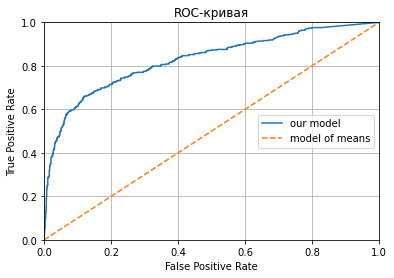

In [30]:
probabilities_valid = best_mod_forest.predict_proba(f_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(t_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(["our model", "model of means"], loc="center right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.grid()
plt.title('ROC-кривая')
plt.show()

В каком-то смысле неплохо: кривая несколько устремляется при определенном пороге вероятности к желаемому значению 1 для TPR, "держась" на минимуме для FPR. Однако все равно далее достаточно быстро начинает расти и FPR (в любом случае от этого не уйти, т.к. при уменьшении порога число истинноположительных ответов вырастет, как и ложноположительных...)

## Тестирование модели

Проверим работу лучшей модели на тестовых данных.

In [36]:
predictions_forest = best_mod_forest.predict(f_test)
print("Оценка точности и полноты в виде метрики f1 для тестовой выборки:", f1_score(t_test, predictions_forest))

Оценка точности и полноты в виде метрики f1 для тестовой выборки: 0.597938144329897


Так или иначе удалось добиться требуемого результата на тестовой выборке, что в целом неплохо. Переобучения не наблюдается.

In [37]:
print('Площадь под кривой ROC для валидационной выборки:', roc_auc_score(t_valid, probabilities_one_valid))
probabilities_test = best_mod_forest.predict_proba(f_test)
probabilities_one_test = probabilities_test[:, 1]
print('Площадь под кривой ROC для тестовой выборки:', roc_auc_score(t_test, probabilities_one_test))

Площадь под кривой ROC для валидационной выборки: 0.827733805551691
Площадь под кривой ROC для тестовой выборки: 0.8438179743985272


Получается, что площадь под тестовой кривой даже чуть выше. По крайней мере, это значение выше чем значений для случайно модели (0,5) и такую предсказательную модель можно считать приемлемой.

[Text(33.0, 0.5, 'reality'), Text(0.5, 15.0, 'predicts')]

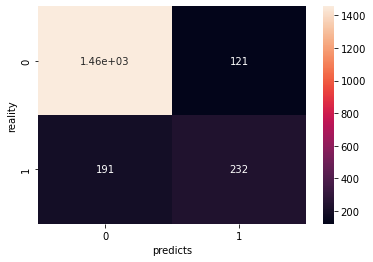

In [38]:

n_metric = confusion_matrix(t_test, predictions_forest)
ax = sns.heatmap(n_metric, annot=True, fmt='.3g')

ax.set(ylabel='reality', xlabel ='predicts')

По confusion_matrix видим, что достаточно много ложноположительных ответов (FP) и точность в таком случае равна 0.65, а полнота 0.55. Значение не высокие, однако позволяют добиться вышеуказанной величины f1 метрики.

In [39]:
# объединяем тренировочную и валидационную выборки
f_pre = pd.concat([f_test] + [f_valid])
t_pre = pd.concat([t_test] + [t_valid])

In [40]:
# рассчитываем метрики по объединенной выборке 
predictions_forest = best_mod_forest.predict(f_pre)
print("Оценка точности и полноты в виде метрики f1 для тестовой выборки:", f1_score(t_pre, predictions_forest))

probabilities_pre = best_mod_forest.predict_proba(f_pre)
probabilities_one_pre = probabilities_pre[:, 1]
print('Площадь под кривой ROC для тестовой выборки:', roc_auc_score(t_pre, probabilities_one_pre))

Оценка точности и полноты в виде метрики f1 для тестовой выборки: 0.6138996138996139
Площадь под кривой ROC для тестовой выборки: 0.8359408729338706


f-1 метрика в общем улучшилась, что, наверное, логично: часть выборки f-pre использовалась при обучении (не все данные "незнакомые").

[Text(33.0, 0.5, 'reality'), Text(0.5, 15.0, 'predicts')]

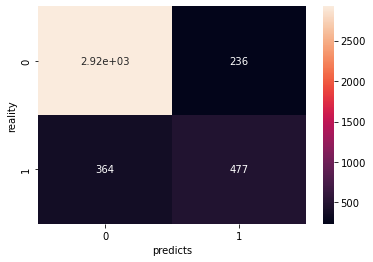

In [41]:

n_metric = confusion_matrix(t_pre, predictions_forest)
ax = sns.heatmap(n_metric, annot=True, fmt='.3g')

ax.set(ylabel='reality', xlabel ='predicts')

Естественно, в абсолютных величинах все показатели выросли (как истинные так и ложные). Причем все примерно в 1.9-2.1 раза.

## Дополнительные вычисления

<div class="alert alert-info"> Блок доп. вычислений и поиска оптимальных решений (в выводе к проекту не задействуется, т.к. тесты мы уже провеои) </div>


In [42]:
df2 = df.drop(['RowNumber', 'Surname'], axis=1)

df2['Tenure'] = df2['Tenure'].fillna(df2['Tenure'].median())

df2 = pd.get_dummies(data=df2, columns=['Gender', 'Geography'], drop_first=True)

df2

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0
9996,15569892,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0
9997,15584532,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,15682355,772,42,3.0,75075.31,2,1,0,92888.52,1,1,1,0


In [43]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

features = df2.drop(['Exited'], axis=1)
target = df2['Exited']
f_train, f_pre, t_train, t_pre = train_test_split(features, target, test_size=0.4, random_state=12345)
f_valid, f_test, t_valid, t_test = train_test_split(f_pre, t_pre, test_size=0.5, random_state=12345)

scaler = StandardScaler()
scaler.fit(f_train[numeric])
f_train[numeric] = scaler.transform(f_train[numeric])
f_valid[numeric] = scaler.transform(f_valid[numeric])
f_test[numeric] = scaler.transform(f_test[numeric])

In [44]:
result2 = 0
best_mod_forest = None
best_res2_forest = 0
best_n_estimators = 0
best_depth_rtree = 0
best_samples_split = 0
best_n_features = 0

for  est in range(10, 15):
    for depth in range(10, 15):
        for sample_split in range(5, 12):
            for n_feature  in range(5, df1.shape[1]-1):
                model_f_bal = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_split=sample_split,
                                                 max_features=n_feature, random_state=12345, class_weight='balanced')
                model_f_bal.fit(f_train, t_train)
                predictions_forest = model_f_bal.predict(f_valid)
                result2 = f1_score(t_valid, predictions_forest)

                if result2 > best_res2_forest:
                        best_res2_forest = result2
                        best_mod_forest = model_f_bal
                        best_n_estimators = est
                        best_depth_rtree = depth
                        best_samples_split = sample_split
                        best_n_features = n_feature
                        
print(f'Лучшая метрика f1 равна {best_res2_forest} при этом:')
print(f'глубина дерева: {best_depth_rtree}; число деревьев: {best_n_estimators}; \
минимальное количество образцов для разделения: {best_samples_split}, число признаков для разделения: {best_n_features}.')

Лучшая метрика f1 равна 0.63 при этом:
глубина дерева: 11; число деревьев: 11; минимальное количество образцов для разделения: 5, число признаков для разделения: 6.


0.6014851485148516


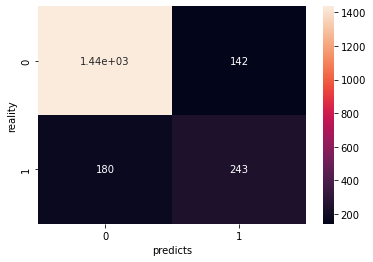

In [45]:
predictions_forest = best_mod_forest.predict(f_test)
n_metric = confusion_matrix(t_test, predictions_forest)
ax = sns.heatmap(n_metric, annot=True, fmt='.3g')

ax.set(ylabel='reality', xlabel ='predicts')
print(f1_score(t_test, predictions_forest))

Результат даже несколько лучше, чем когда не учитывали CustomerId, но у нас ложных 1 стало больше (как и истинных 1), а ложных 0 наоборот немного меньше. 

Может быть не следовало брать медианное значение для Tenure, а просто удалить эти пропуски?

In [46]:
df2 = df.drop(['RowNumber', 'CustomerId' , 'Surname'], axis=1)

df2 = df2.dropna(subset=['Tenure'])
df2 = df2.reset_index(drop=True)

df2 = pd.get_dummies(data=df2, columns=['Gender', 'Geography'], drop_first=True)
display(df2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9086,800,29,2.0,0.00,2,0,0,167773.55,0,0,0,0
9087,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0
9088,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0
9089,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0


In [47]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

features = df2.drop(['Exited'], axis=1)
target = df2['Exited']
f_train, f_pre, t_train, t_pre = train_test_split(features, target, test_size=0.4, random_state=12345)
f_valid, f_test, t_valid, t_test = train_test_split(f_pre, t_pre, test_size=0.5, random_state=12345)

scaler = StandardScaler()
scaler.fit(f_train[numeric])
f_train[numeric] = scaler.transform(f_train[numeric])
f_valid[numeric] = scaler.transform(f_valid[numeric])
f_test[numeric] = scaler.transform(f_test[numeric])

In [48]:
result2 = 0
best_mod_forest = None
best_res2_forest = 0
best_n_estimators = 0
best_depth_rtree = 0
best_samples_split = 0
best_n_features = 0

for  est in range(10, 15):
    for depth in range(10, 15):
        for sample_split in range(5, 12):
            for n_feature  in range(5, df1.shape[1]-1):
                model_f_bal = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_split=sample_split,
                                                 max_features=n_feature, random_state=12345, class_weight='balanced')
                model_f_bal.fit(f_train, t_train)
                predictions_forest = model_f_bal.predict(f_valid)
                result2 = f1_score(t_valid, predictions_forest)

                if result2 > best_res2_forest:
                        best_res2_forest = result2
                        best_mod_forest = model_f_bal
                        best_n_estimators = est
                        best_depth_rtree = depth
                        best_samples_split = sample_split
                        best_n_features = n_feature
                        
print(f'Лучшая метрика f1 равна {best_res2_forest} при этом:')
print(f'глубина дерева: {best_depth_rtree}; число деревьев: {best_n_estimators}; \
минимальное количество образцов для разделения: {best_samples_split}, число признаков для разделения: {best_n_features}.')

Лучшая метрика f1 равна 0.6424870466321243 при этом:
глубина дерева: 10; число деревьев: 13; минимальное количество образцов для разделения: 5, число признаков для разделения: 7.


0.5851063829787234


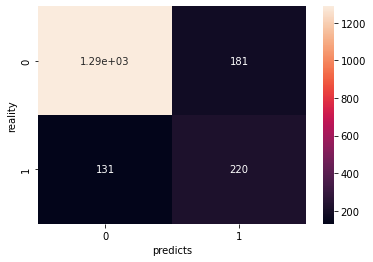

In [49]:
predictions_forest = best_mod_forest.predict(f_test)
n_metric = confusion_matrix(t_test, predictions_forest)
ax = sns.heatmap(n_metric, annot=True, fmt='.3g')

ax.set(ylabel='reality', xlabel ='predicts')
print(f1_score(t_test, predictions_forest))

При валидации показатель f1 явно был лучше, чем при тестовой выборке, заметно определенное несильное переобучение. Видимо идея с удалением лишних строк была тоже нелучшей. Но возможно здесь была лучший результат дала техника upsampling или downsampling. На этом приостановим данные изыскания.

Тут можно попробовать и сам признак с пустыми значениями удалить и еще что-то скомбинировать.



## *Общий вывод*

(без учета дополнительныз расчетов)

 конкретно по текущему исследованию можно отметить что мы добились требуемого значения f1, однако если обратиться к общим результатам получается, что модель будет дочтаточно часто ставить 1 (пользователь уйдет) тем, кто этого не самом деле не сделает (121 человеку). Примерно на две "правильных" 1 будет одна ложная (TP = 232)... Ложных 0 в абсолютном количестве также немало (даже больше чем ложных 1), однако в отношении истинных 0 это значение не такое большое. В любом случае 191 человеку она спрогнозирует "не уйдет" в то время, как этот пользователь уйдет из банка. 
 
 Отметим, что процесс построения "удачной" модели МО явно итерационный и найти превосходную по всем показателем весьма затруднительно, может быть и невозможнно. Так или иначе придется чем-то жертвовать в зависимости от контекста задачи.
 
 *Такой результат вряд ли может быть применим на практике*.